# AGIPD Geometry and Azimuthal Integration

In this example, we will show you how to assemble the modules of the AGIPD detector into a single image and then perform azimuthal integration.

In [1]:
import multiprocessing as mp
import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from extra_data import RunDirectory, stack_detector_data
from pyfoamalgo.geometry import AGIPD_1MGeometry
from pyfoamalgo import AzimuthalIntegrator, mask_image_data, nanmean

mp.cpu_count()

80

In [2]:
run = RunDirectory("/gpfs/exfel/exp/XMPL/201750/p700000/proc/r0005")

run.info()

# of trains:    156
Duration:       0:00:15.6
First train ID: 198425241
Last train ID:  198425396

16 detector modules (SPB_DET_AGIPD1M-1)
  e.g. module SPB_DET_AGIPD1M-1 0 : 512 x 128 pixels
  SPB_DET_AGIPD1M-1/DET/0CH0:xtdf
  176 frames per train, up to 27456 frames total

0 instrument sources (excluding detectors):

0 control sources: (1 entry per train)



In [3]:
_, train_data = run.select('*/DET/*', 'image.data').train_from_index(100)

## Assembling

**Note:** By passing ``real_array=False`` in the function ``stack_detector_data``, it actually returns an array-like wrapper around the existing arrays. Otherwise, the data will be copied which can be time-consuming.

In [4]:
# Stack the detector modules into a single array.
modules_data = stack_detector_data(train_data, 'image.data', real_array=False)

modules_data.shape, modules_data.dtype

((176, 16, 512, 128), dtype('<f4'))

In [5]:
geom = AGIPD_1MGeometry.from_crystfel_geom('agipd_mar18_v11.geom')

In [6]:
n_pulses = modules_data.shape[0]

# Allocate the assembled image array and reuse it as far as possible to speed up data processing.
assembled = geom.output_array_for_position_fast(extra_shape=(n_pulses,), dtype=np.float32)
assembled.shape

(176, 1259, 1092)

In [7]:
t0 = time.perf_counter()

geom.position_all_modules(modules_data, out=assembled)

print(f"Assembling a train with {n_pulses} pulses takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

Assembling a train with 176 pulses takes: 70.4 ms


In [8]:
t0 = time.perf_counter()

# Calculate the average (taking into account nan) of the assembled image.
assembled_mean = nanmean(assembled, axis=0)

print(f"Averaging a train with {n_pulses} pulses takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

Averaging a train with 176 pulses takes: 37.4 ms


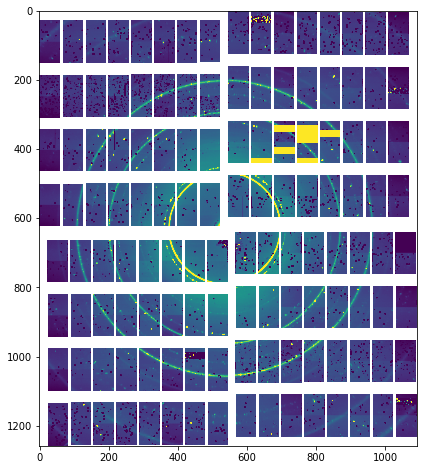

In [9]:
_, ax = plt.subplots(figsize=(8, 8))

ax.imshow(assembled_mean, vmin=0, vmax=1000)

## Azimuthal integration

In [10]:
# The mask is only required by pyFAI. pyfoamalgo can process nans without a mask.
mask = np.zeros_like(assembled_mean, dtype=bool)
# The threshold mask here is important for both libraries to have a reasonable result.
mask_image_data(assembled_mean, threshold_mask=(0, 5e4), out=mask)

In [11]:
dist = 5.5  # sample distance in meter
npt = 1024  # number of integration points
cy, cx = 628, 536
pixel1, pixel2 = 200e-6, 200e-6  # pixel size (y, x) in meter
poni1, poni2 = cy * pixel1, cx * pixel2  # integration center (y, x)
wavelength = 1e-10  # Xray wavelength in meter

integrator = AzimuthalIntegrator(
    dist=dist, poni1=poni1, poni2=poni2, pixel1=pixel1, pixel2=pixel2, wavelength=1e-10)

t0 = time.perf_counter()
integrator.integrate1d(assembled_mean, npt=npt)
print(f"Azimuthal integration (including initialization) takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

t0 = time.perf_counter()
q, I = integrator.integrate1d(assembled_mean, npt=npt)
print(f"Azimuthal integration takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

Azimuthal integration (including initialization) takes: 19.6 ms
Azimuthal integration takes: 8.7 ms


One can benchmark the result using [pyFAI](https://github.com/silx-kit/pyFAI) if it is installed.

In [12]:
HAS_PYFAI = False

try:
    from pyFAI.azimuthalIntegrator import AzimuthalIntegrator as PyfaiAzimuthalIntegrator
    
    HAS_PYFAI = True

    pyfai_method = 'nosplit_csr'
    pyfai_integrator = PyfaiAzimuthalIntegrator(
        dist=dist, poni1=poni1, poni2=poni2, pixel1=pixel1, pixel2=pixel2, wavelength=wavelength)

    t0 = time.perf_counter()
    pyfai_integrator.integrate1d(assembled_mean, npt, 
                                 mask=mask, 
                                 unit="q_A^-1", 
                                 method=pyfai_method)
    print(f"Azimuthal integration (including initialization) takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

    t0 = time.perf_counter()
    q_gt, I_gt = pyfai_integrator.integrate1d(assembled_mean, npt, 
                                              mask=mask, 
                                              unit="q_A^-1", 
                                              method=pyfai_method)
    print(f"Azimuthal integration takes: {1e3 * (time.perf_counter() - t0):.1f} ms")
except ModuleNotFoundError:
    pass

Azimuthal integration (including initialization) takes: 222.5 ms
Azimuthal integration takes: 16.9 ms


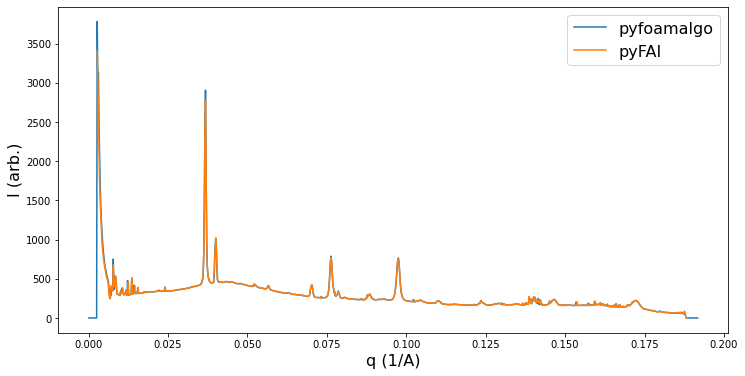

In [13]:
_, ax = plt.subplots(figsize=(12, 6))

ax.plot(1e-10 * q, I, '-', label='pyfoamalgo')
ax.set_xlabel("q (1/A)", fontsize=16)
ax.set_ylabel("I (arb.)", fontsize=16)
if HAS_PYFAI:
    ax.plot(q_gt, I_gt, '-', label='pyFAI')
    ax.legend(fontsize=16)

One can also perform azimuthal integration on an array of images in a batch.

In [14]:
mask_image_data(assembled, threshold_mask=(0, 5e4))

t0 = time.perf_counter()
q, I_a = integrator.integrate1d(assembled, npt=npt)
print(f"Averaging a train with {n_pulses} pulses takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

Averaging a train with 176 pulses takes: 46.9 ms


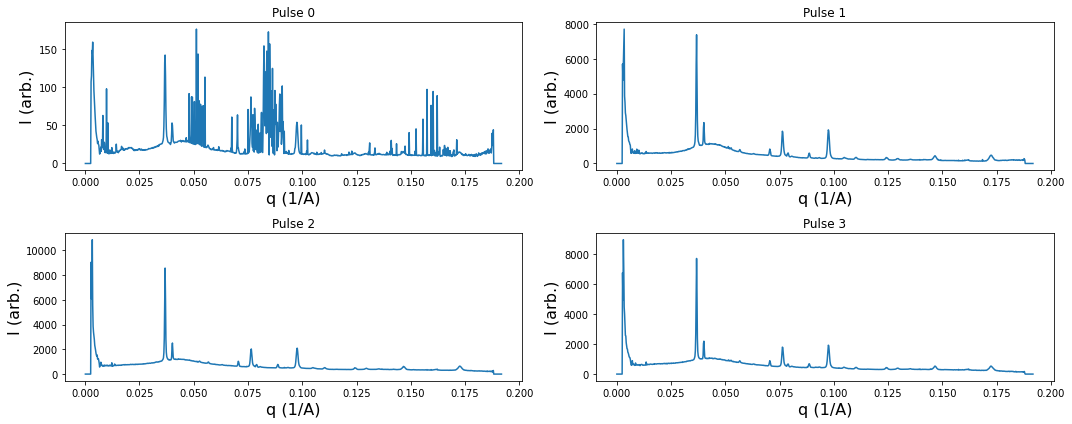

In [15]:
_, ax = plt.subplots(2, 2, figsize=(15, 6))

for i, axis in enumerate(ax.flatten()):
    axis.plot(1e-10 * q, I_a[i], '-')
    axis.set_xlabel("q (1/A)", fontsize=16)
    axis.set_ylabel("I (arb.)", fontsize=16)
    axis.set_title(f"Pulse {i}")
    
plt.tight_layout()